# IT 302
## Assignment 1

### Name: Niraj Nandish
### Roll no.: 191IT234

### Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

### Reading the dataset

In [2]:
df = pd.read_csv('spam_ham_dataset.csv')

In [3]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


### Splitting of data into two sets ie. train & test set

In [4]:
X = df.text
y = df.label_num

In [5]:
skf = model_selection.StratifiedKFold(n_splits=5)

In [6]:
train, test = next(skf.split(X, y))

In [7]:
X_train, X_test = X.iloc[train], X.iloc[test]
y_train, y_test = y[train], y[test]

## Preprocessing
### Vector of counts of unique words in a sentence

In [8]:
count_vectorizer = feature_extraction.text.CountVectorizer(min_df=100, stop_words='english')

In [9]:
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [10]:
X_train_counts_df = pd.DataFrame(X_train_counts.toarray())
y_t = y_train.reset_index(drop=True)
X_train_counts_df['label'] = y_t

## Bayesian model
### P(A) = Total probability of mail being spam
### P(B) = Probabilty of particular word occuring
### P(B/A) = Conditional Probability of word occuring in a spam mail
### P(A/B) = Probability that given mail is marked as spam

In [11]:
total_prob = {}
total_prob[1] = (X_train_counts_df[X_train_counts_df['label'] == 1].sum()).sum()/(X_train_counts_df.sum()).sum()
total_prob[0] = 1 - total_prob[1]

In [12]:
mean = {}
variance = {}
for i in X_train_counts_df.columns:
    mean[i] = X_train_counts_df.loc[X_train_counts_df['label'] == 1, i].mean()
    variance[i] = X_train_counts_df.loc[X_train_counts_df['label'] == 1, i].var()

In [13]:
condition_probability = {}
sum_df = (X_train_counts_df[X_train_counts_df['label'] == 1].sum()).sum()
for i in X_train_counts_df.columns:
    try: 
        if i != 'label':
            condition_probability[i] = X_train_counts_df.loc[X_train_counts_df['label'] == 1, i].sum()/sum_df
    except:
        print(i)

In [14]:
def pXY(x, mean_y, variance_y):
    p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))
    if p != p:
        p = 1
    return p

In [15]:
y_pred = []
rows = len(X_train_counts_df)
for row in range(rows):
    val =  total_prob[1].astype('float64')
    for col in X_train_counts_df.columns:
        if col != 'label':
            val *= pXY(X_train_counts_df.loc[row, col], mean[col], variance[col])
    y_pred.append(val)

/var/folders/y5/2fpl3jcd4tl5zqfkd89ppzt00000gn/T/ipykernel_24559/203041936.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))
/var/folders/y5/2fpl3jcd4tl5zqfkd89ppzt00000gn/T/ipykernel_24559/203041936.py:2: RuntimeWarning: invalid value encountered in double_scalars
  p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))


## ROC score

In [16]:
from sklearn import metrics
score = metrics.roc_auc_score(y_train, y_pred)
score

0.896685695689547

## Precision & Recall curve
### Finding best threshold value

In [17]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train, y_pred)

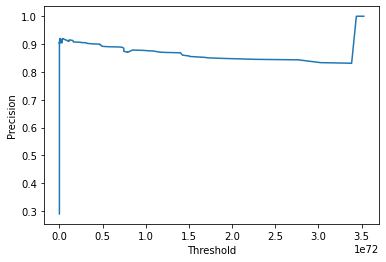

In [18]:
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.plot(thresholds, precision[:-1])
plt.show()

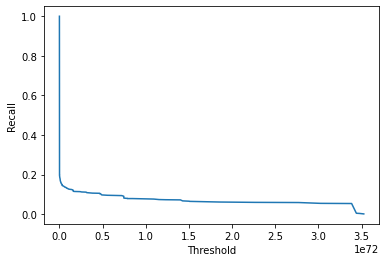

In [19]:
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.plot(thresholds, recall[:-1])
plt.show()

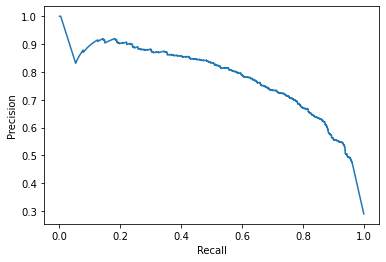

In [20]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)
plt.show()

### It can be seen that the curve is roughly inversely proportional

In [21]:
y_label = y_pred.copy()
for i, val in enumerate(y_label):
    y_label[i] = val > 1e-10

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_label))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2937
           1       0.70      0.78      0.73      1199

    accuracy                           0.84      4136
   macro avg       0.80      0.82      0.81      4136
weighted avg       0.84      0.84      0.84      4136



The best threshold is 1e-10, it can be observed from the precision and recall graph that we need to select a point such that none of the two are compromised. Hence, selecting 1e-10 ensures that neither precision nor recall are too low.

## Evaluation Metrics for test set

In [23]:
y_pred_test = []
X_test_counts_df = pd.DataFrame(X_test_counts.toarray())
rows = len(X_test_counts_df)
for row in range(rows):
    val =  total_prob[1].astype('float64')
    for col in X_test_counts_df.columns:
        if col != 'label':
            val *= pXY(X_test_counts_df.loc[row, col], mean[col], variance[col])
    y_pred_test.append(val)

/var/folders/y5/2fpl3jcd4tl5zqfkd89ppzt00000gn/T/ipykernel_24559/203041936.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))
/var/folders/y5/2fpl3jcd4tl5zqfkd89ppzt00000gn/T/ipykernel_24559/203041936.py:2: RuntimeWarning: invalid value encountered in double_scalars
  p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))


In [24]:
y_label = y_pred_test.copy()
for i, val in enumerate(y_label):
    y_label[i] = val > 1e-10

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       735
           1       0.73      0.79      0.76       300

    accuracy                           0.86      1035
   macro avg       0.82      0.84      0.83      1035
weighted avg       0.86      0.86      0.86      1035



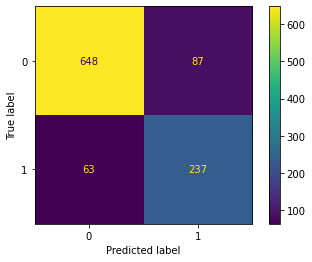

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_label)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## It can be observed that the proportion of False Positives and True Negatives are small. The prediction is a bit skewed because we are using probability directly for prediction.